<a href="https://colab.research.google.com/github/LuisRoblero01/Redes-Neuronales-Recurrentes-RNN-/blob/main/Proyecto_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO 1: Predicción del precio de Bitcoin usando LSTM**

El objetivo de este proyecto es desarollar una Red Neuronal Recurrente (RNN), para predecir el precio de la criptomodena *'Bitcoin'*, usando el modelo LSTM (Long Short-Term Memory).

Se utiliza la plaatforma *Kaggle* para la recuperación de una base de datos, la cual contiene un archivo CSV para determinados intercambios bitcoin para el período de tiempo de enero 2012 hasta marzo 2025 (Medido por día UTC), con actualizaciones minuto a minuto de OHLC (Open, High, Low, Close) y Volumen en BTC.

**CONTENIDO:**
* **Timestamp:** Hora de inicio de la ventana de tiempo (ventana de 60s), en tiempo Unix.
* **Open:** Precio de apertura en la ventana horaria de inicio.
* **High:** Precio alto en la ventana horaria de inicio.
* **Low:** Precio bajo en la ventana horaria de inicio.
* **Close:** Precio de cierre en la ventana horaria de inicio.
* **Volume:** Volumen de BTC negociado en esta ventana.
* **datetime:** Fecha y hora.

In [2]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

# Datos
files = os.listdir(path)
print(files)

['btcusd_1-min_data.csv']


In [3]:
data = pd.read_csv(os.path.join(path, 'btcusd_1-min_data.csv'))
data

<ipython-input-3-67fb3761554d>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(path, 'btcusd_1-min_data.csv'))


,Timestamp,Open,High,Low,Close,Volume,datetime
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:01:00+00:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:02:00+00:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:03:00+00:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:04:00+00:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000,2012-01-01 10:05:00+00:00
...,...,...,...,...,...,...,...
7000999,1.745542e+09,93879.00,93887.00,93878.00,93887.00,0.008724,NaN
7001000,1.745542e+09,93881.00,93928.00,93880.00,93928.00,0.145513,NaN
7001001,1.745542e+09,93932.00,93932.00,93931.00,93932.00,0.016023,NaN
7001002,1.745542e+09,93932.00,93932.00,93932.00,93932.00,0.004300,NaN


## **Análisis exploratorio**

Se inicia con un análisis exploratorio para comprobar la calidad de la base de datos y así evitar problemas de inconsistencia durante el entrenamiento.

Así mismo, debido a la gran cantidad de filas (producto de la actualización minuto por minuto), se propone modificar el dataset a actualizaciones diarias.

In [4]:
data.dtypes

,0
Timestamp,float64
Open,float64
High,float64
Low,float64
Close,float64
Volume,float64
datetime,object


In [5]:
# Convertir la columna de fecha
data['datetime'] = pd.to_datetime(data['datetime'])
data.dtypes

,0
Timestamp,float64
Open,float64
High,float64
Low,float64
Close,float64
Volume,float64
datetime,"datetime64[ns, UTC]"


In [6]:
# Verificar Null
print('Null Values:', data.isnull().sum())

Null Values: Timestamp         0
Open              0
High              0
Low               0
Close             0
Volume            0
datetime     218724
dtype: int64


In [7]:
# Crear nueva columna 'datetime' desde 'timestamp'
data['datetime'] = pd.to_datetime(data['Timestamp'], unit='s')
print(data[['Timestamp', 'datetime']].head())
print()

# Verificar nuevamente los nulls
print(data.isnull().sum())

      Timestamp            datetime
0  1.325412e+09 2012-01-01 10:01:00
1  1.325412e+09 2012-01-01 10:02:00
2  1.325412e+09 2012-01-01 10:03:00
3  1.325412e+09 2012-01-01 10:04:00
4  1.325412e+09 2012-01-01 10:05:00

Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
datetime     0
dtype: int64


In [8]:
data.set_index('datetime', inplace=True)

# Agrupar por día
data = data.resample('1D').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

data = data.reset_index()
data.head()

,datetime,Open,High,Low,Close,Volume
0,2012-01-01,4.58,4.84,4.58,4.84,10.000000
1,2012-01-02,4.84,5.00,4.84,5.00,10.100000
2,2012-01-03,5.00,5.32,5.00,5.29,107.085281
3,2012-01-04,5.29,5.57,4.93,5.57,107.233260
4,2012-01-05,5.57,6.46,5.57,6.42,70.328742


In [9]:
fecha_inicio = data['datetime'].min()
fecha_final = data['datetime'].max()

print(f'Fecha de inicio: {fecha_inicio}')
print(f'Fecha de término: {fecha_final}')

Fecha de inicio: 2012-01-01 00:00:00
Fecha de término: 2025-04-25 00:00:00


In [10]:
data.describe()

,datetime,Open,High,Low,Close,Volume
count,4864,4864.000000,4864.000000,4864.000000,4864.000000,4864.000000
mean,2018-08-28 12:00:00,17306.724005,17721.517981,16874.625518,17325.942428,7640.546299
min,2012-01-01 00:00:00,4.380000,4.380000,3.800000,4.380000,0.000000
25%,2015-04-30 18:00:00,424.115000,432.190000,416.000000,424.345000,2112.990104
50%,2018-08-28 12:00:00,6570.500000,6762.670000,6428.195000,6580.515000,4784.587162
75%,2021-12-26 06:00:00,27198.000000,27742.250000,26754.250000,27205.000000,9927.746789
max,2025-04-25 00:00:00,106187.000000,109356.000000,105363.000000,106187.000000,127286.486533
std,NaN,23919.899102,24443.392384,23369.077458,23943.734665,9110.227154


In [11]:
data.corr()

,datetime,Open,High,Low,Close,Volume
datetime,1.000000,0.796043,0.795926,0.796789,0.796128,-0.305079
Open,0.796043,1.000000,0.999647,0.999478,0.999273,-0.314226
High,0.795926,0.999647,1.000000,0.999346,0.999675,-0.311557
Low,0.796789,0.999478,0.999346,1.000000,0.999597,-0.318789
Close,0.796128,0.999273,0.999675,0.999597,1.000000,-0.314739
Volume,-0.305079,-0.314226,-0.311557,-0.318789,-0.314739,1.000000


## **Preprocesamiento para LSTM**

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Normalización de los datos
df = data[['Open', 'High', 'Low', 'Close', 'Volume']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
scaled_df['datetime'] = data['datetime'].values

scaled_df.head()

,Open,High,Low,Close,Volume,datetime
0,0.000002,0.000004,0.000007,0.000004,0.000079,2012-01-01
1,0.000004,0.000006,0.000010,0.000006,0.000079,2012-01-02
2,0.000006,0.000009,0.000011,0.000009,0.000841,2012-01-03
3,0.000009,0.000011,0.000011,0.000011,0.000842,2012-01-04
4,0.000011,0.000019,0.000017,0.000019,0.000553,2012-01-05


In [13]:
import numpy as np

tamaño_ventana = 1

X = []
y = []

# Usamos 'Close' como variable a predecir
for i in range(tamaño_ventana, len(scaled_df)):
    X.append(scaled_df[['Open', 'High', 'Low', 'Close', 'Volume']].iloc[i-tamaño_ventana:i].values)
    y.append(scaled_df['Close'].iloc[i])

X = np.array(X)
y = np.array(y)

print(f'Forma de X: {X.shape}')
print(f'Forma de y: {y.shape}')

Forma de X: (4863, 1, 5)
Forma de y: (4863,)


In [14]:
# Dividir datos de entrenamiento y prueba
split = int(0.8 * len(X))

X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

print(f'Tamaño X_train: {X_train.shape}')
print(f'Tamaño X_test: {X_test.shape}')

Tamaño X_train: (3890, 1, 5)
Tamaño X_test: (973, 1, 5)


## **Entrenamiento**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0225 - val_loss: 0.0090
Epoch 2/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 6.9394e-04
Epoch 3/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 6.4082e-04
Epoch 4/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 5.8340e-04
Epoch 5/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.6556e-04 - val_loss: 6.2104e-04
Epoch 6/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0461e-04 - val_loss: 3.6431e-04
Epoch 7/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0454e-04 - val_loss: 3.2290e-04
Epoch 8/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4718e-04 - val_loss: 3.5634e-04
Epoch 9/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4244e-04 - val_loss: 4.5118e-04
Epoch 10/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.5314e-04 - val_loss: 2.4731e-04
Epoch 11/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.9689e-04 - val_

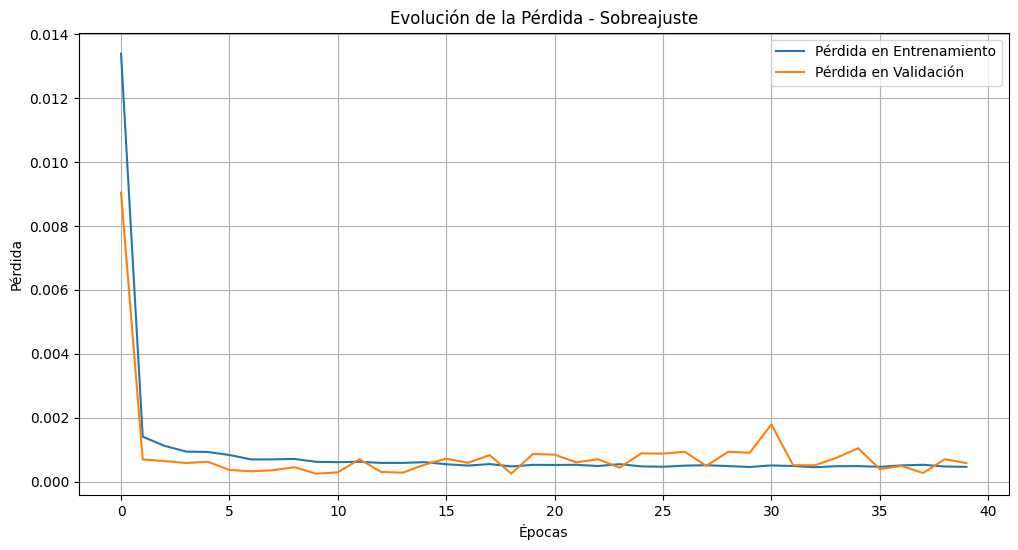

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 6))
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Evolución de la Pérdida - Sobreajuste")
plt.legend()
plt.grid()
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


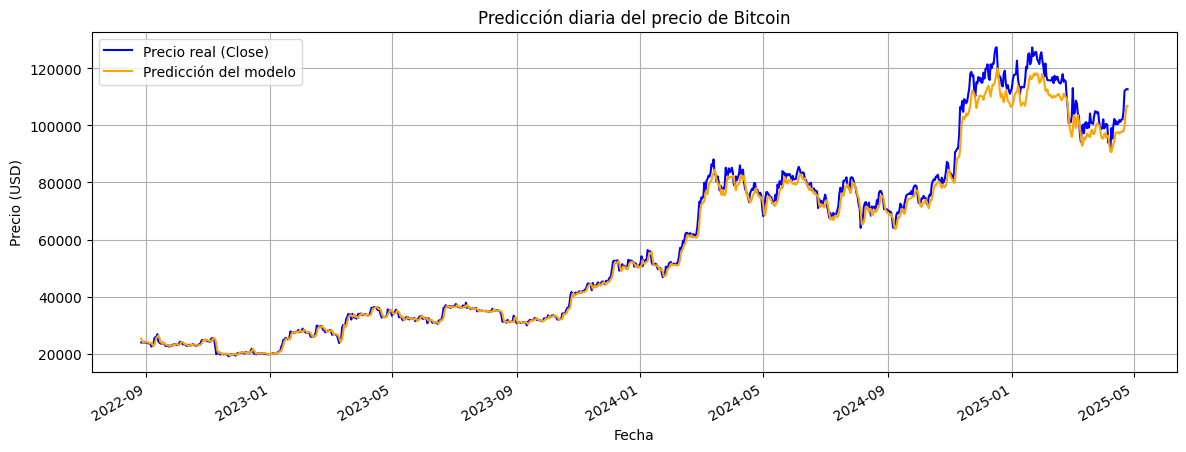

In [18]:
y_pred = model.predict(X_test)
fechas = scaled_df['datetime'][tamaño_ventana + split:].reset_index(drop=True)

# Invertir escalado
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_pred.shape[0], 4)), y_pred), axis=1))[:, -1]
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((y_test.shape[0], 4)), y_test.reshape(-1,1)), axis=1))[:, -1]

plt.figure(figsize=(14,5))
plt.plot(fechas, y_test_inv, label='Precio real (Close)', color='blue')
plt.plot(fechas, y_pred_inv, label='Predicción del modelo', color='orange')
plt.title('Predicción diaria del precio de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid(True)

plt.gcf().autofmt_xdate()
plt.show()